<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# Load Keras-TF model and check predictions

The goal of this notebook is to load a saved Keras model created by the TF script, then to process a raw Aquaplanet file and get predictions. Finally, we would like to compare the predictions to the target output.

Little primer on Jupyter notebooks: Ctrl + Enter will execute a cell.

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import netCDF4 as nc
import h5netcdf as h5py
from dataLoad import *
from config import *
from utils import *
import subprocess
import os
import math
import json
import logging
import numpy as np
from PIL import Image
from datetime import datetime
from folderDefs import *
import configargparse
from keras import layers
from keras.models import model_from_json
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the latest model and the corresponding mean and standard deviation files.

Define the paths where the model and the mean and std files are stored. For me its all the same directory, so you might have to adapt.

In [2]:
model_dir = '../RESULTS/CBRAIN-nolat-nonorm/0313_013747_TPHYSTND_NORAD,PHQ_layers_32,32,32,32_lr_0.00025_lrstep_200000_ac_leakyrelu_conv_False_locconv_False_vars_TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_256_loss_mse/'

In [3]:
model_name = 'saved_keras_model'

In [4]:
mean_file = './mean_nolat.nc'
std_file = './std_nolat.nc'

In [5]:
#model = keras.models.load_model(model_dir + model_fn, custom_objects={"tf": tf})
#model = tf.keras.models.load_model(model_dir + model_fn)
model=keras.models.load_model(model_dir + '/' + model_name + '.h5', custom_objects={"tf": tf})

/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4736      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [7]:
# somthing is going wrong here, not saving the right weights and biases
from keras import layers
print(model.layers[2].get_weights()[0]) # for weight 
print(model.layers[2].get_weights()[1]) #for bias
#print(model.layers[4].get_weights()[0]) # for weight 
#print(model.layers[4].get_weights()[1]) #for bias
#print(model.layers[6].get_weights()[0]) # for weight 
#print(model.layers[6].get_weights()[1]) #for bias
#print(weights)
# checked those are correct

[[-0.13670845 -0.14001669  0.1486631  ...  0.05559988 -0.03741745
   0.10173247]
 [-0.03742105 -0.03171495  0.04096279 ... -0.04505089  0.1510153
  -0.17034972]
 [ 0.01703151  0.0380435   0.09895228 ...  0.06409188 -0.14135247
  -0.1598015 ]
 ...
 [-0.03814611  0.01003739  0.0320227  ...  0.01914149  0.0480713
   0.00103369]
 [ 0.02459689  0.0271671  -0.01350785 ... -0.01530115 -0.04772857
   0.03717611]
 [-0.01350001 -0.00239     0.03064756 ...  0.00363568  0.00070326
  -0.03731421]]
[-0.03670901  0.12575382  0.1422098  -0.08353563 -0.05062124 -0.0340898
  0.01026657 -0.00701943 -0.16298787  0.04505087 -0.11505194  0.03108224
  0.0400811  -0.126391   -0.11392312  0.01241308 -0.01543861 -0.05348863
 -0.03516225 -0.14758137 -0.06301261  0.02479039 -0.10662974 -0.23577625
  0.02356394 -0.02635733 -0.06749293 -0.09432507  0.07856615 -0.09618086
 -0.1002465  -0.11957401]


So here is the model which takes 9 input variables with 21 levels each and returns two output variables. In-between we have two fully connected layers with leaky ReLU activations.

In [8]:
mean = nc.Dataset(mean_file)
std = nc.Dataset(std_file)

In [9]:
mean

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): level(30), lats(1), lon(1)
    variables(dimensions): float32 QAP(level,lats,lon), float32 TAP(level,lats,lon), float32 QBP(level,lats,lon), float32 TBP(level,lats,lon), float32 dTdt_adiabatic(level,lats,lon), float32 dQdt_adiabatic(level,lats,lon), float32 SPDT(level,lats,lon), float32 SPDQ(level,lats,lon), float32 TPHYSTND_NORAD(level,lats,lon), float32 PHQ(level,lats,lon), float32 SHFLX(lats,lon), float32 LHFLX(lats,lon), float32 PS(), float32 lat(), float32 SOLIN()
    groups: 

The mean and standard deviation variables have 3 dimensions, but lat and lon only have size 1.

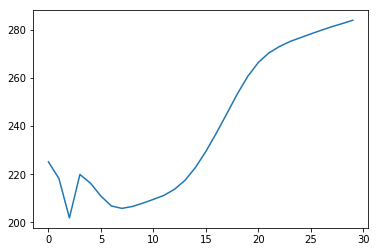

In [10]:
plt.plot(mean['TAP'][:, 0, 0])

## Load an Aquaplanet file and process as input for NN

These files have been preprocessed with the matlab script to compute derived variables

In [11]:
#data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old/'
#aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
data_dir = '/Users/gentine/Dropbox/Collaborations_Projects/CONN/SP-CAM/Pritchard_Aquaplanet/'   # New file directly from Pierre!
aqua_fn = 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc'  # Just randomly grab a file

In [12]:
aqua = nc.Dataset(data_dir + aqua_fn)

In [13]:
aqua

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0
    title: 
    logname: tg802402
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    history: Tue Feb  6 09:26:27 2018: /anaconda3/bin/ncks -x -v TPHYSTND_NORAD --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:26 2018: /anaconda3/bin/ncks -x -v QBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc
Tue Feb  6 09:26:24 2018: /anaconda3/bin/ncks -x -v TBP --overwrite --output=./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.nc ./Pritchard_Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-02-00000.n

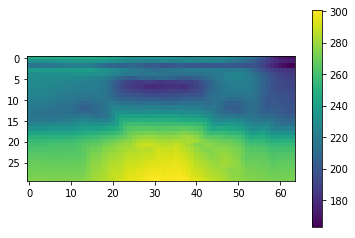

In [14]:
# Let's plot one input and one output variable
plt.imshow(aqua['TAP'][-1, :, :, 0]);
plt.colorbar();

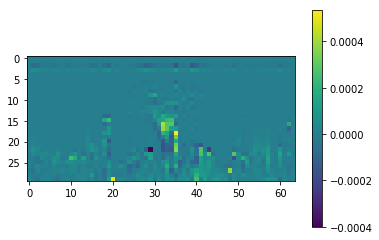

In [15]:
plt.imshow(aqua['TPHYSTND_NORAD'][-1, :, :, 0]);
plt.colorbar();

Now define the input and output variables. They need to be in the right order!

In [16]:
inps = ['TAP','QAP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']

In [17]:
outps = ['TPHYSTND_NORAD','PHQ']

The following script takes each variable, normalizes it by subtracting the mean and dividing by the standard deviation. Then the 2D variables (PS) are tiled to fill the 30 levels. We do this for the input and output array.

Note that additionally the vertical axis is flipped.

In [18]:
folderPath = '../SP-CAM/Pritchard_Aquaplanet/'
rawFileBase= 'AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00001.nc'
config = load_config(model_dir, subset=None)
print(config)
a = DataLoader(folderPath, config, rawFileBase)

[read] PARAM path: ../RESULTS/CBRAIN-nolat-nonorm/0313_013747_TPHYSTND_NORAD,PHQ_layers_32,32,32,32_lr_0.00025_lrstep_200000_ac_leakyrelu_conv_False_locconv_False_vars_TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_256_loss_mse/params.json
Namespace(act='leakyrelu', addon='', batch_size=256, beta1=0.5, beta2=0.999, convert_units=False, convo=False, data_dir='data', data_format='NCHW', data_path='data/TPHYSTND_NORAD,PHQ', donotnormalizeOutputs=True, epoch=200, filter_size=3, frac_train=0.8, gamma=0.5, hidden='32,32,32,32', input_names='TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic', is_train=True, keep_dropout_rate=1.0, lambda_k=0.001, load_path='', local=False, localConvo=False, log_dir='logs', log_level='INFO', log_step=50, lossfct='mse', lr=0.00025, lr_lower_boundary=2e-08, lr_update_epoch=1, lr_update_step=200000, max_step=1000000, model_dir='logs/0313_013747_TPHYSTND_NORAD,PHQ_layers_32,32,32,32_lr_0.00025_lrstep_200000_ac_leakyrelu_conv_False_locconv_False_vars

In [19]:
#fileReader = folderPath + rawFileBase
#print(fileReader)
#print(config.input_names.split(","))
# select time of the data iTim
iTim = 1
#inX = a.prepareData(aqua, iTim, doLog=True)
print(a.config.normalizeInoutputs)
print(a.config.convert_units)
print(a.config.donotnormalizeOutputs)
print(a.varAllList)
inputvars=a.config.input_names.split(',')
print(inputvars)
X = a.accessTimeData(aqua, a.varAllList, iTim, doLog=False)
print(X.shape)
nlev = X.shape[1]
print(nlev)
X=np.asarray(X)

True
False
True
['TBP', 'QBP', 'PS', 'SHFLX', 'LHFLX', 'dTdt_adiabatic', 'dQdt_adiabatic', 'TPHYSTND_NORAD', 'PHQ']
['TBP', 'QBP', 'PS', 'SHFLX', 'LHFLX', 'dTdt_adiabatic', 'dQdt_adiabatic']
(9, 21, 64, 128)
21


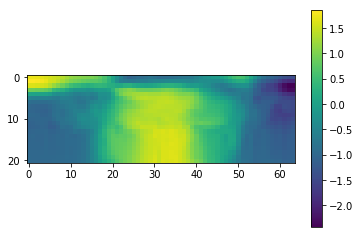

In [20]:
longindex = 64
plt.imshow(X[0,-nlev:,:,longindex]) # print tempoerature, first index, check if normalized
plt.colorbar();

In [21]:
# now change dimensions (7, 30, 64, 128) -> (8192, 7, 30, 1)
print(X.shape[:2])
#print(X.shape[:2]+[-1])
shapes = X.shape
print(shapes)
#X = tf.reshape(X, [X.shape[:2],-1])# first flatten last domension
X = np.reshape(X, (shapes[0],shapes[1],-1))# first flatten last dimension
print(X.shape)

(9, 21)
(9, 21, 64, 128)
(9, 21, 8192)


In [22]:
X = np.transpose(X, [2,0,1]) # now swap axes
print(X.shape)
X = np.expand_dims(X, -1) # insert a new axis that will appear at the axis position
print(X.shape)
X = X[:,:,-nlev:,:][:,:,::-1] # switch vertical levels top to bottom
print(X.shape)

(8192, 9, 21)
(8192, 9, 21, 1)
(8192, 9, 21, 1)


In [23]:
# how many inputs
ninputvars = len(inputvars)
preds = model.predict(np.float64(X[:,0:ninputvars,:,:]))
print(preds.shape)

(8192, 2, 21, 1)


(64, 128, 2, 21)
(64, 21)
(64, 21)


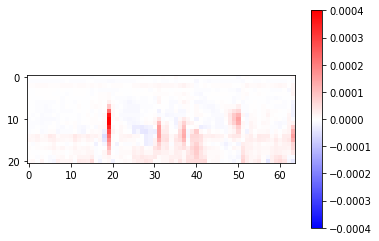

In [24]:
predsplot = np.reshape(preds, (shapes[2],shapes[3],-1,nlev))# reshape prediction
print(predsplot.shape)
vartoplot = 0 # 0 for SPDT and 1 for SPDQ
toshow = predsplot[:,longindex,vartoplot,:]
print(toshow.shape)
print(toshow[:,-nlev:].shape)
#plt.imshow(toshow)
toshow = np.transpose(toshow[:,::-1],[1,0]) # vertical axis is flipped
plt.imshow(toshow, cmap=plt.cm.bwr) # Vertical axis is flipped.
plt.colorbar();
plt.clim(-4e-4,4e-4)

(30, 64)
(48, 30, 64, 128)


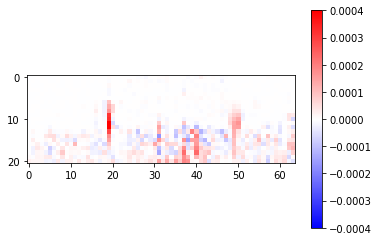

In [25]:
# compare to expectation
output = aqua['TPHYSTND_NORAD'][iTim-1, :, :, longindex]
print(output.shape)
output = output[output.shape[0]-nlev:output.shape[0],:]
plt.imshow(output, cmap=plt.cm.bwr)
plt.colorbar();
print(aqua['TPHYSTND_NORAD'].shape)
plt.clim(-4e-4,4e-4)

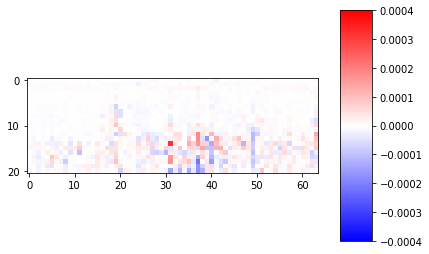

In [26]:
# now compare outputs :). I love machine learning! 
plt.imshow(toshow-output, cmap=plt.cm.bwr)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.clim(-4e-4,4e-4)

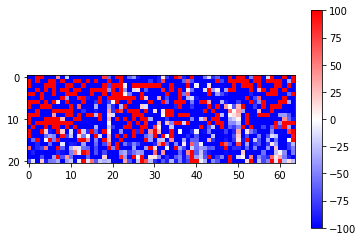

In [27]:
# now compare outputs :). I love machine learning! 
# percent error
plt.imshow(100*(toshow-output)/output, cmap=plt.cm.bwr)
plt.colorbar();
plt.clim(-100,100)

(30, 64)


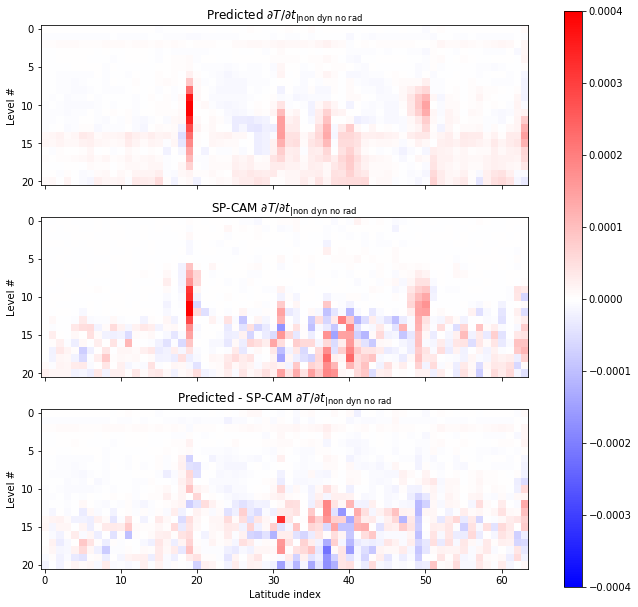

In [38]:
# publishable plots
output = aqua['TPHYSTND_NORAD'][iTim-1, :, :, longindex]
print(output.shape)
output = output[output.shape[0]-nlev:output.shape[0],:]
vartoplot = 0 # 0 for SPDT and 1 for SPDQ
toshow = predsplot[:,longindex,vartoplot,:]
toshow = np.transpose(toshow[:,::-1],[1,0]) # vertical axis is flipped


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(311)
plt.imshow(toshow, cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
plt.ylabel('Level #')
ax.set_xticklabels('')
plt.title(r'Predicted $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
ax = plt.subplot(312)
plt.imshow(output,cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
ax.set_xticklabels('')
plt.ylabel('Level #')
plt.title(r'SP-CAM $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
ax = plt.subplot(313)
plt.imshow(toshow-output, cmap=plt.cm.bwr)
plt.ylabel('Level #')
plt.xlabel('Latitude index')
plt.clim(-4e-4,4e-4)
plt.title(r'Predicted - SP-CAM $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.9, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.show(block=False)
fig.savefig('./Figures/dTdt_profile.pdf')
fig.savefig('./Figures/dTdt_profile.tiff')
fig.savefig('./Figures/dTdt_profile.png', dpi=fig.dpi)

#fig.set_size_inches(100, 100, forward=True)
#plt.rcParams["figure.figsize"] = (50,50)




(30, 64)


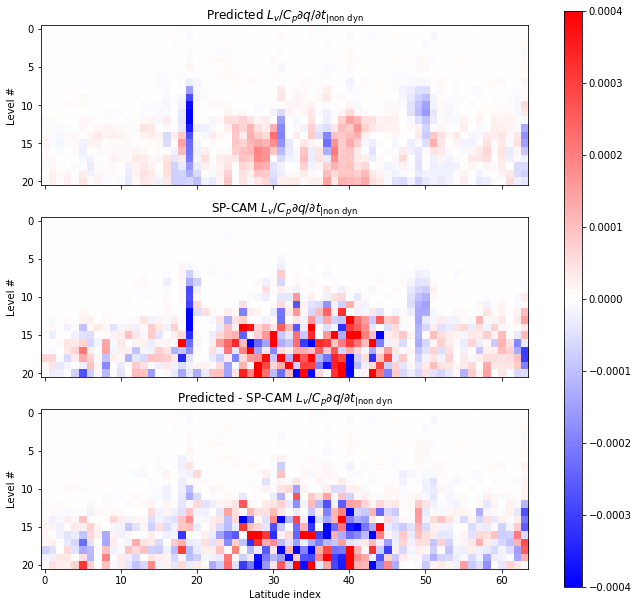

In [39]:
Lv = 2.5e6
Cp = 1000
output = Lv/Cp*aqua['PHQ'][iTim-1, :, :, longindex]
print(output.shape)
output = output[output.shape[0]-nlev:output.shape[0],:]
vartoplot = 1 # 0 for SPDT and 1 for SPDQ
toshow = np.mean(predsplot[:,longindex,vartoplot,:],3)



# publishable plots
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(311)
plt.imshow(toshow, cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
plt.ylabel('Level #')
ax.set_xticklabels('')
plt.title(r'Predicted $L_v/C_p \partial q/\partial t_{|\rm non \ dyn}$')
ax = plt.subplot(312)
plt.imshow(output,cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
ax.set_xticklabels('')
plt.ylabel('Level #')
plt.title(r'SP-CAM $L_v/C_p \partial q/\partial t_{|\rm non \ dyn}$')
ax = plt.subplot(313)
plt.imshow(toshow-output, cmap=plt.cm.bwr)
plt.ylabel('Level #')
plt.xlabel('Latitude index')
plt.clim(-4e-4,4e-4)
plt.title(r'Predicted - SP-CAM $L_v/C_p \partial q/\partial t_{|\rm non \ dyn}$')
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.9, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.show(block=False)
fig.savefig('./Figures/dqdt_profile.pdf')
fig.savefig('./Figures/dqdt_profile.tiff')
fig.savefig('./Figures/dqdt_profile.png', dpi=fig.dpi)

#fig.set_size_inches(100, 100, forward=True)
#plt.rcParams["figure.figsize"] = (50,50)


In [56]:
# publishable plots
# take mean value across levels
output = np.mean(aqua['TPHYSTND_NORAD'][iTim-1, 30-nlev:30, :, :],0)
print(output.shape)
#output = output[output.shape[0]-nlev:output.shape[0],:]
vartoplot = 0 # 0 for SPDT and 1 for SPDQ
predsplot = np.reshape(preds, (shapes[2],shapes[3],-1,nlev))# reshape prediction
print(predsplot.shape)
toshow = np.mean(predsplot[:,:,vartoplot,:],2)
print(toshow.shape)



(64, 128)
(64, 128, 2, 21)
(64, 128)


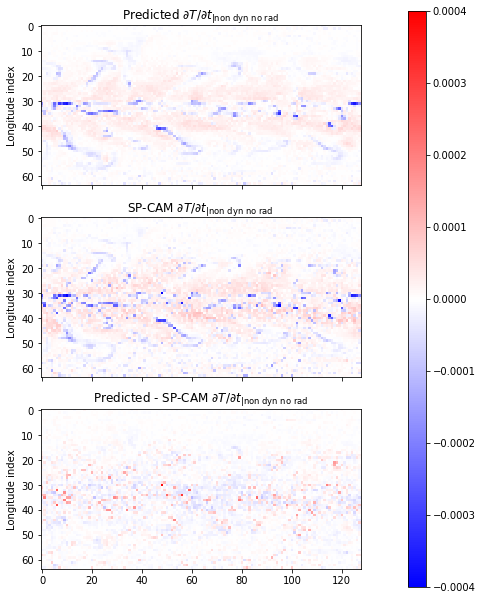

In [64]:


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(311)
plt.imshow(toshow, cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
plt.ylabel('Longitude index')
ax.set_xticklabels('')
plt.title(r'Predicted $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
ax = plt.subplot(312)
plt.imshow(output,cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
ax.set_xticklabels('')
plt.ylabel('Longitude index')
plt.title(r'SP-CAM $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
ax = plt.subplot(313)
plt.imshow(toshow-output, cmap=plt.cm.bwr)
plt.ylabel('Level #')
plt.ylabel('Longitude index')
plt.clim(-4e-4,4e-4)
plt.title(r'Predicted - SP-CAM $\partial T/\partial t_{|\rm non \ dyn \ no \ rad}$')
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.8, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.show(block=False)
fig.savefig('./Figures/dTdt_latlon.pdf')
fig.savefig('./Figures/dTdt_latlon.tiff')
fig.savefig('./Figures/dTdt_latlon.png', dpi=fig.dpi)

#fig.set_size_inches(100, 100, forward=True)
#plt.rcParams["figure.figsize"] = (50,50)


In [58]:
# publishable plots
# take mean value across levels
output = Lv/Cp*np.mean(aqua['PHQ'][iTim-1, 30-nlev:30, :, :],0)
print(output.shape)
#output = output[output.shape[0]-nlev:output.shape[0],:]
vartoplot = 1 # 0 for SPDT and 1 for SPDQ
predsplot = np.reshape(preds, (shapes[2],shapes[3],-1,nlev))# reshape prediction
print(predsplot.shape)
toshow = np.mean(predsplot[:,:,vartoplot,:],2)
print(toshow.shape)

(64, 128)
(64, 128, 2, 21)
(64, 128)


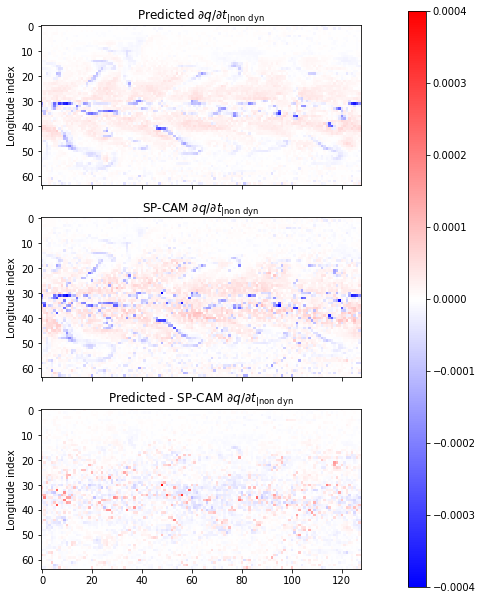

In [63]:

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(311)
plt.imshow(toshow, cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
plt.ylabel('Longitude index')
ax.set_xticklabels('')
plt.title(r'Predicted $\partial q/\partial t_{|\rm non \ dyn }$')
ax = plt.subplot(312)
plt.imshow(output,cmap=plt.cm.bwr)
plt.clim(-4e-4,4e-4)
ax.set_xticklabels('')
plt.ylabel('Longitude index')
plt.title(r'SP-CAM $\partial q/\partial t_{|\rm non \ dyn}$')
ax = plt.subplot(313)
plt.imshow(toshow-output, cmap=plt.cm.bwr)
plt.ylabel('Level #')
plt.ylabel('Longitude index')
plt.clim(-4e-4,4e-4)
plt.title(r'Predicted - SP-CAM $\partial q/\partial t_{|\rm non \ dyn}$')
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.8, 0.1, 0.025, 0.8])
plt.colorbar(cax=cax)
plt.show(block=False)
fig.savefig('./Figures/dqdt_latlon.pdf')
fig.savefig('./Figures/dqdt_latlon.tiff')
fig.savefig('./Figures/dqdt_latlon.png', dpi=fig.dpi)

#fig.set_size_inches(100, 100, forward=True)
#plt.rcParams["figure.figsize"] = (50,50)
